In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
from utils import Normalise, RandomCrop, ToTensor, RandomMirror
import torchvision.transforms as transforms
from dataloader import HydranetDataset
from convolutions import conv1x1,convbnrelu,conv3x3,InvertedResidualBlock,CRPBlock

In [3]:
img_scale = 1.0 / 255
depth_scale = 5000.0

img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

normalise_params = [img_scale, img_mean.reshape((1, 1, 3)), img_std.reshape((1, 1, 3)), depth_scale,]
transform_common = [Normalise(*normalise_params), ToTensor()]

In [4]:
crop_size = 400
transform_train = transforms.Compose([RandomMirror(), RandomCrop(crop_size)] + transform_common)
transform_val = transforms.Compose(transform_common)

In [5]:
train_batch_size = 4
val_batch_size = 4
train_file = "train_list_depth.txt"
val_file = "val_list_depth.txt"

In [6]:
from torch.utils.data import DataLoader

#TRAIN DATALOADER
trainloader = DataLoader(HydranetDataset(train_file,transform = transform_train),batch_size = train_batch_size,shuffle=True,num_workers=4,pin_memory=True,drop_last=True)

# VALIDATION DATALOADER
valloader = DataLoader(HydranetDataset(val_file,transform = transform_val),batch_size = val_batch_size,shuffle=True,num_workers=4,pin_memory=True,drop_last=True)

In [7]:
test = next(iter(trainloader))

In [8]:
test["image"]

tensor([[[[ 1.7180,  1.6667,  1.6667,  ..., -0.1486, -0.1486, -0.1486],
          [ 1.6667,  1.6838,  1.7352,  ..., -0.1486, -0.1657, -0.1486],
          [ 1.6667,  1.7009,  1.7523,  ..., -0.1657, -0.1828, -0.1657],
          ...,
          [ 1.6324,  1.6324,  1.6324,  ..., -0.6794, -0.6794, -0.6965],
          [ 1.5982,  1.6153,  1.6324,  ..., -0.6623, -0.6794, -0.7137],
          [ 1.5810,  1.5810,  1.5982,  ..., -0.6794, -0.6794, -0.6965]],

         [[ 1.6758,  1.6408,  1.6408,  ..., -0.5476, -0.5301, -0.5301],
          [ 1.6232,  1.6583,  1.7108,  ..., -0.5476, -0.5651, -0.5301],
          [ 1.6232,  1.6758,  1.7283,  ..., -0.5651, -0.5826, -0.5651],
          ...,
          [ 1.2556,  1.2731,  1.2731,  ..., -0.8102, -0.8102, -0.8277],
          [ 1.2206,  1.2381,  1.2556,  ..., -0.7927, -0.8102, -0.8452],
          [ 1.2031,  1.2206,  1.2381,  ..., -0.8102, -0.8102, -0.8277]],

         [[ 2.1346,  2.0997,  2.0997,  ..., -0.3578, -0.3753, -0.4101],
          [ 2.0823,  2.1171,  

In [9]:
class MobileNetv2(nn.Module):
    def __init__(self, return_idx=[6]):
        super().__init__()
        # expansion rate, output channels, number of repeats, stride
        self.mobilenet_config = [
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
        ]
        self.in_channels = 32  # number of input channels
        self.num_layers = len(self.mobilenet_config)
        self.layer1 = convbnrelu(3, self.in_channels, kernel_size=3, stride=2)
    
        self.return_idx = [1, 2, 3, 4, 5, 6]
        #self.return_idx = make_list(return_idx)

        c_layer = 2
        for t, c, n, s in self.mobilenet_config:
            layers = []
            for idx in range(n):
                layers.append(InvertedResidualBlock(self.in_channels,c,expansion_factor=t,stride=s if idx == 0 else 1,))
                self.in_channels = c
            setattr(self, "layer{}".format(c_layer), nn.Sequential(*layers))
            c_layer += 1

        self._out_c = [self.mobilenet_config[idx][1] for idx in self.return_idx] # Output: [24, 32, 64, 96, 160, 320]

    def forward(self, x):
        outs = []
        x = self.layer1(x)
        outs.append(self.layer2(x))  # 16, x / 2
        outs.append(self.layer3(outs[-1]))  # 24, x / 4
        outs.append(self.layer4(outs[-1]))  # 32, x / 8
        outs.append(self.layer5(outs[-1]))  # 64, x / 16
        outs.append(self.layer6(outs[-1]))  # 96, x / 16
        outs.append(self.layer7(outs[-1]))  # 160, x / 32
        outs.append(self.layer8(outs[-1]))  # 320, x / 32
        return [outs[idx] for idx in self.return_idx]

In [10]:
encoder = MobileNetv2()
encoder.load_state_dict(torch.load("mobilenetv2-e6e8dd43.pth"))

<All keys matched successfully>

In [11]:
encoder._out_c

[24, 32, 64, 96, 160, 320]

In [12]:
def make_list(x):
    """Returns the given input as a list."""
    if isinstance(x, list):
        return x
    elif isinstance(x, tuple):
        return list(x)
    else:
        return [x]

In [13]:
def _make_crp(in_planes, out_planes, stages, groups=False):
    layers = [CRPBlock(in_planes, out_planes,stages, groups=groups)]
    return nn.Sequential(*layers)

In [14]:
class MTLWRefineNet(nn.Module):
    def __init__(self, input_sizes, num_classes, agg_size=256, n_crp=4):
        super().__init__()

        stem_convs = nn.ModuleList()
        crp_blocks = nn.ModuleList()
        adapt_convs = nn.ModuleList()
        heads = nn.ModuleList()

        # Reverse since we recover information from the end
        input_sizes = list(reversed((input_sizes)))

        # No reverse for collapse indices is needed
        self.collapse_ind = [[0, 1], [2, 3], 4, 5]

        groups = [False] * len(self.collapse_ind)
        groups[-1] = True

        for size in input_sizes:
            stem_convs.append(conv1x1(size, agg_size, bias=False))

        for group in groups:
            crp_blocks.append(self._make_crp(agg_size, agg_size, n_crp, group))
            adapt_convs.append(conv1x1(agg_size, agg_size, bias=False))

        self.stem_convs = stem_convs
        self.crp_blocks = crp_blocks
        self.adapt_convs = adapt_convs[:-1]

        num_classes = list(num_classes)
        for n_out in num_classes:
            heads.append(
                nn.Sequential(
                    conv1x1(agg_size, agg_size, groups=agg_size, bias=False),
                    nn.ReLU6(inplace=False),
                    conv3x3(agg_size, n_out, bias=True),
                )
            )

        self.heads = heads
        self.relu = nn.ReLU6(inplace=True)

    def forward(self, xs):
        xs = list(reversed(xs))
        for idx, (conv, x) in enumerate(zip(self.stem_convs, xs)):
            xs[idx] = conv(x)

        # Collapse layers
        c_xs = [sum([xs[idx] for idx in make_list(c_idx)]) for c_idx in self.collapse_ind ]

        for idx, (crp, x) in enumerate(zip(self.crp_blocks, c_xs)):
            if idx == 0:
                y = self.relu(x)
            else:
                y = self.relu(x + y)
            y = crp(y)
            if idx < (len(c_xs) - 1):
                y = self.adapt_convs[idx](y)
                y = F.interpolate(
                    y,
                    size=c_xs[idx + 1].size()[2:],
                    mode="bilinear",
                    align_corners=True,
                )

        outs = []
        for head in self.heads:
            outs.append(head(y))
        return outs

    @staticmethod
    def _make_crp(in_planes, out_planes, stages, groups):
        # Same as previous, but showing the use of a @staticmethod
        layers = [CRPBlock(in_planes, out_planes, stages, groups)]
        return nn.Sequential(*layers)
num_classes = (40, 1)   
decoder = MTLWRefineNet(encoder._out_c,num_classes)

In [15]:
test["image"].squeeze().shape

torch.Size([4, 3, 400, 400])

In [16]:
batch_size = 4
height, width = 32, 32  # Example spatial dimensions

inputs = [torch.randn(batch_size, size, height, width) for size in encoder._out_c]
outputs = decoder(inputs)
for i, output in enumerate(outputs):
    print(f"Output {i} shape: {output.shape}")
decoder.forward(inputs)

Output 0 shape: torch.Size([4, 40, 32, 32])
Output 1 shape: torch.Size([4, 1, 32, 32])


[tensor([[[[-2.4825e-01, -3.9172e-01, -2.9259e-01,  ..., -3.2719e-01,
            -4.4018e-01, -1.5713e-01],
           [-3.0075e-01, -4.5797e-01, -3.1558e-01,  ..., -2.3440e-01,
            -6.0768e-01, -3.9137e-02],
           [-2.6653e-01, -3.8118e-01, -9.9514e-02,  ..., -3.3063e-01,
            -4.2861e-01, -1.4340e-02],
           ...,
           [-3.0275e-01, -3.3796e-01, -2.4900e-01,  ..., -4.9855e-01,
            -3.8935e-01, -1.6698e-01],
           [-3.0345e-01, -3.3842e-01, -2.8758e-01,  ..., -4.8315e-01,
            -5.6128e-01, -9.3399e-02],
           [-7.2662e-02, -1.1951e-01, -1.2939e-01,  ..., -2.0430e-01,
            -2.7631e-01, -1.1921e-01]],
 
          [[-7.2147e-02,  2.2920e-02,  2.4842e-02,  ...,  7.9033e-02,
             2.2522e-01,  1.9718e-01],
           [ 3.6324e-02,  1.2328e-01,  9.3345e-02,  ..., -4.8176e-02,
             1.6624e-01,  1.6612e-01],
           [ 6.6948e-02,  2.1607e-01,  7.7115e-02,  ..., -5.0683e-02,
             2.4732e-03,  1.8659e-01],


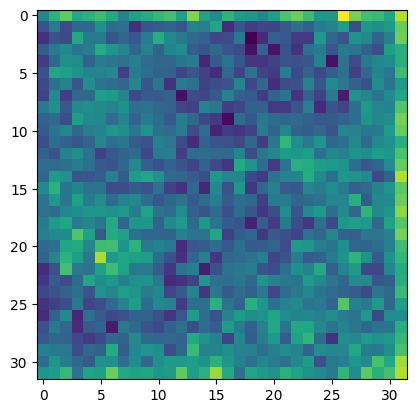

In [17]:
plt.imshow(output[2].permute(1,2,0).detach().numpy())

In [18]:
import cv2
img = cv2.imread(r"C:\Users\kagad\Vishal\hydranets\nyud\depth\000001.png")

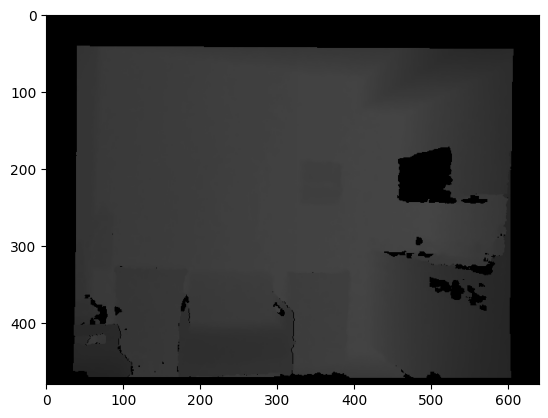

In [19]:
plt.imshow(img)

In [20]:
from utils import InvHuberLoss

ignore_index = 255
ignore_depth = 0

loss_fn_seg = nn.CrossEntropyLoss(ignore_index=ignore_index).cuda()
loss_fn_depth = InvHuberLoss(ignore_index=ignore_depth).cuda()

In [21]:
lr_encoder = 1e-2
lr_decoder = 1e-3
momentum_encoder = 0.9
momentum_decoder = 0.9
weight_decay_encoder = 1e-5
weight_decay_decoder = 1e-5

In [22]:
optims = [torch.optim.SGD(encoder.parameters(), lr=lr_encoder, momentum=momentum_encoder, weight_decay=weight_decay_encoder), #optimzer for encoder
         torch.optim.SGD(decoder.parameters(), lr=lr_decoder, momentum=momentum_decoder, weight_decay=weight_decay_decoder)] #optimizer for decoder

In [23]:
n_epochs = 1000

In [24]:
from model_helpers import Saver, load_state_dict
import operator 
import json
import logging

init_vals = (0.0, 10000.0)
comp_fns = [operator.gt, operator.lt]
ckpt_dir = "./"
ckpt_path = "./checkpoint.pth.tar"

saver = Saver(
    args=locals(),
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

In [25]:
hydranet = nn.DataParallel(nn.Sequential(encoder, decoder).cuda()) # Use .cpu() if you prefer a slow death

print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))

start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
load_state_dict(hydranet, state_dict)

if start_epoch is None:
    start_epoch = 0

Model has 3070057 parameters


In [26]:
opt_scheds = []
for opt in optims:
    opt_scheds.append(torch.optim.lr_scheduler.MultiStepLR(opt, np.arange(start_epoch + 1, n_epochs, 100), gamma=0.1))

In [27]:
opt_scheds

In [28]:
from utils import AverageMeter
#from model_helpers import get_input_and_targets
from tqdm import tqdm

In [39]:
def train(model, opts, dataloader,crits, loss_coeffs=(1.0,), grad_norm=0.0,):
    model.train()
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:

        loss = 0.0

        input = sample["image"].float().to(device)
        targets =[sample[k].to(device) for k in dataloader.dataset.masks_names] #trainloader.dataset.masks_names = ["segm","depth"]
        outputs = model(input)

    for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
        loss += loss_coeff * crit(
            F.interpolate(
                out, size=target.size()[1:], mode="bilinear", align_corners=False
            ).squeeze(dim=1),
            target.squeeze(dim=1),
        )

    # Backward
    for opt in opts:
        opt.zero_grad()
    loss.backward()
    if grad_norm > 0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
    for opt in opts:
        opt.step()

    loss_meter.update(loss.item())
    pbar.set_description(
        "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
    )
            

In [40]:
def validate(model, metrics, dataloader):
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    model.eval()
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            # Get the Data
            input = sample["image"].float().to(device)
            targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]

            #input, targets = get_input_and_targets(sample=sample, dataloader=dataloader, device=device)
            targets = [target.squeeze(dim=1).cpu().numpy() for target in targets]

            # Forward
            outputs = model(input)
            #outputs = make_list(outputs)

            # Backward
            for out, target, metric in zip(outputs, targets, metrics):
                metric.update(
                    F.interpolate(out, size=target.shape[1:], mode="bilinear", align_corners=False)
                    .squeeze(dim=1)
                    .cpu()
                    .numpy(),
                    target,
                )
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals

In [41]:
from utils import MeanIoU, RMSE

In [42]:
crop_size = 400
batch_size = 4
val_batch_size = 4
val_every = 5
loss_coeffs = (0.5, 0.5)

for i in range(start_epoch, n_epochs):
    for sched in opt_scheds:
        sched.step(i)
    
    print("Epoch {:d}".format(i))
    train(hydranet, optims, [loss_fn_seg, loss_fn_seg], trainloader, loss_coeffs)
    
    if i % val_every == 0:
        metrics = [MeanIoU(num_classes[0]),RMSE(ignore_val=ignore_depth),]

        with torch.no_grad():
            vals = validate(hydranet, metrics, valloader)
        saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

c:\Users\kagad\anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 50


  0%|          | 0/2 [00:00<?, ?it/s]


TypeError: 'CrossEntropyLoss' object is not subscriptable

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
for sample in trainloader:
    loss = 0.0
    input = sample["image"].float().to(device)
    targets = [sample[k].to(device) for k in trainloader.dataset.masks_names] #trainloader.dataset.masks_names = ["segm","depth"]
    crits = [loss_fn_seg,loss_fn_depth]
    loss_coeffs=(1.0,)
    
    outputs = hydranet(input)
    print(outputs)
    for out, target, crit, loss_coeff in zip(outputs, targets, crits,loss_coeffs):
        loss += loss_coeff * crit(
            F.interpolate(
                out, size=target.size()[1:], mode="bilinear", align_corners=False
            ).squeeze(dim=1),
            target.squeeze(dim=1),
        )
    break

